# Winsorization demo on Medical Student Mental Health dataset

Este notebook carga los archivos del dataset (codebook y datos), realiza una exploración básica,
aplica **winsorización por percentiles (5% y 95%)** sobre variables numéricas seleccionadas y
genera gráficos **antes vs. después** para visualizar el impacto.

> Nota de implementación: Se utiliza `pandas` puro (sin `feature-engine`) para evitar dependencias,
> siguiendo la receta del Capítulo 5 (*Applying winsorization*) del libro de Soledad Galli.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración de gráficos
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True

## 1. Carga de datos

In [6]:
# Rutas a los archivos (asegúrate de que estén en el mismo directorio del notebook o ajusta la ruta)
codebook_path = "Codebook Carrard et al. 2022 MedTeach.csv"
data_path     = "Data Carrard et al. 2022 MedTeach.csv"

codebook = pd.read_csv(codebook_path, sep=None, engine="python")
data = pd.read_csv(data_path, sep=None, engine="python")

print("Dimensiones de los datos:", data.shape)
display(data.head())

Dimensiones de los datos: (886, 20)


,id,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea
0,2,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,34,61,17,13,20
1,4,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,7,33,14,11,26
2,9,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,25,73,24,7,23
3,10,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,17,48,16,10,21
4,13,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,14,46,22,14,23


### Vista rápida del codebook

In [7]:
display(codebook.head(10))

,Variable Name,Variable Label,Variable Scale,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,id,Participants ID number,string,NaN,NaN,NaN
1,age,age at questionnaire 20-21,numeric,NaN,NaN,NaN
2,year,CURICULUM YEAR : In which curriculum year are ...,1=Bmed1; 2=Bmed2; 3=Bmed3; 4=Mmed1; 5=Mmed2; 6...,NaN,NaN,NaN
3,sex,GENDER : To which gender do you identify the m...,1=Man; 2=Woman; 3=Non-binary,NaN,NaN,NaN
4,glang,MOTHER TONGUE: What is your mother tongue?,1=French; 15=German; 20=English; 37=Arab; 51=B...,NaN,NaN,NaN
5,part,PARTNERSHIP STATUS : Do you have a partner?,0=No; 1=Yes,NaN,NaN,NaN
6,job,HAVING A JOB : Do you have a paid job?,0=No; 1=Yes,NaN,NaN,NaN
7,stud_h,"HOURS OF STUDY PER WEEK : On average, how many...",NaN,NaN,NaN,NaN
8,health,SATISFACTION WITH HEALTH : How satisfied are y...,1=Verydissatisfied; 2=Dissatisfied; 3=Neithers...,NaN,NaN,NaN
9,psyt,PSYCHOTHERAPY LAST YEAR : During the last 12 m...,0=No; 1=Yes,NaN,NaN,NaN


## 2. Exploración básica

In [8]:
# Información general y estadísticos descriptivos
display(data.describe(include='all'))

# Detectar columnas numéricas
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas numéricas detectadas:", numeric_cols)

,id,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000
mean,889.709932,22.383747,3.102709,1.695260,14.327314,0.563205,0.348758,25.288939,3.777652,0.224605,106.374718,58.525959,34.784424,23.150113,0.720144,18.050790,42.898420,16.878104,10.079007,24.207675
std,515.555875,3.300664,1.763937,0.472665,32.366389,0.496269,0.476847,15.927875,1.061497,0.417558,8.784012,6.570341,5.377062,4.993220,0.093570,11.478731,11.978458,5.256025,4.592609,4.633675
min,2.000000,17.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,67.000000,37.000000,18.000000,6.000000,0.357143,0.000000,20.000000,5.000000,4.000000,10.000000
25%,447.500000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.000000,3.000000,0.000000,101.000000,54.000000,31.000000,20.000000,0.666667,9.000000,34.000000,13.000000,6.000000,21.000000
50%,876.000000,22.000000,3.000000,2.000000,1.000000,1.000000,0.000000,25.000000,4.000000,0.000000,107.000000,58.000000,35.000000,23.000000,0.726190,16.000000,43.000000,17.000000,9.000000,24.000000
75%,1341.750000,24.000000,5.000000,2.000000,1.000000,1.000000,1.000000,36.000000,5.000000,0.000000,113.000000,63.000000,39.000000,26.750000,0.785714,25.000000,51.000000,20.000000,13.000000,28.000000
max,1790.000000,49.000000,6.000000,3.000000,121.000000,1.000000,1.000000,70.000000,5.000000,1.000000,125.000000,76.000000,48.000000,35.000000,0.952381,56.000000,77.000000,30.000000,24.000000,36.000000


Columnas numéricas detectadas: ['id', 'age', 'year', 'sex', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt', 'jspe', 'qcae_cog', 'qcae_aff', 'amsp', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']


### Selección de variables candidatas para winsorización

In [9]:
# Lista de variables típicas de salud mental (si existen en el dataset)
preferred = ['stai_t','cesd','mbi_ex','mbi_cy','mbi_ea','qcae_aff','qcae_cog','jspe','erec_mean']

# Mantener solo las que existan y sean numéricas
vars_candidates = [c for c in preferred if c in numeric_cols]

# Si no se encontraran todas, complementar con otras numéricas (hasta 6 variables)
if len(vars_candidates) < 4:
    extras = [c for c in numeric_cols if c not in vars_candidates and c not in ['id','year','sex','glang','part','job']]
    vars_candidates = vars_candidates + extras[: (6 - len(vars_candidates)) ]

print("Variables seleccionadas para winsorización:", vars_candidates)

Variables seleccionadas para winsorización: ['stai_t', 'cesd', 'mbi_ex', 'mbi_cy', 'mbi_ea', 'qcae_aff', 'qcae_cog', 'jspe', 'erec_mean']


## 3. Winsorización por percentiles (5% y 95%)

In [10]:
def winsorize_by_quantiles(df, cols, lower_q=0.05, upper_q=0.95):
    df_out = df.copy()
    # Calcular percentiles por columna, en base al dataset original
    q_low  = df_out[cols].quantile(lower_q)
    q_high = df_out[cols].quantile(upper_q)
    # Aplicar clipping (recorte) columna a columna
    for c in cols:
        df_out[c] = df_out[c].clip(lower=q_low[c], upper=q_high[c])
    return df_out, q_low, q_high

data_wins, q_low, q_high = winsorize_by_quantiles(data, vars_candidates, 0.05, 0.95)
print("Percentiles inferiores (5%):")
display(q_low.to_frame("p5"))
print("Percentiles superiores (95%):")
display(q_high.to_frame("p95"))

Percentiles inferiores (5%):


,p5
stai_t,24.000000
cesd,2.000000
mbi_ex,8.000000
mbi_cy,4.000000
mbi_ea,17.000000
qcae_aff,25.000000
qcae_cog,48.000000
jspe,91.000000
erec_mean,0.571429


Percentiles superiores (95%):


,p95
stai_t,63.000000
cesd,39.000000
mbi_ex,26.000000
mbi_cy,19.000000
mbi_ea,31.000000
qcae_aff,43.000000
qcae_cog,70.000000
jspe,119.000000
erec_mean,0.857143


In [12]:
# Guardar dataset transformado (opcional)
out_path = "Data_Carrard_MedTeach_winsorized.csv"
data_wins.to_csv(out_path, index=False)
print("Archivo guardado:", out_path)

Archivo guardado: Data_Carrard_MedTeach_winsorized.csv


## 4. Comparación visual: histogramas antes y después

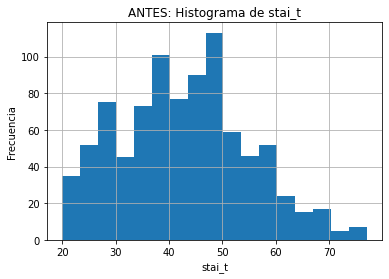

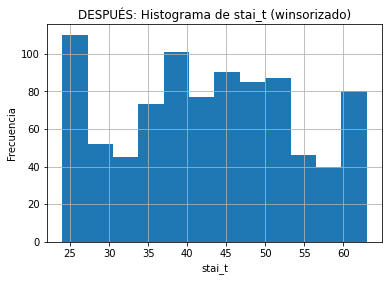

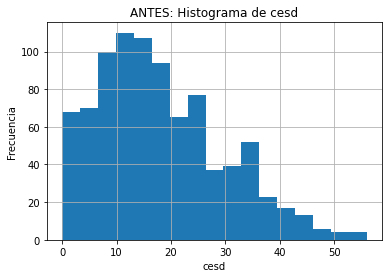

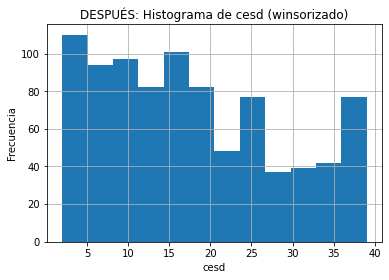

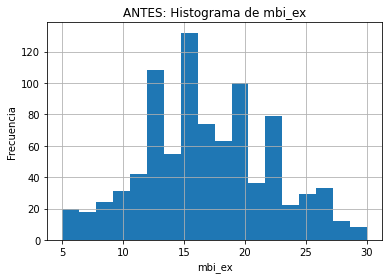

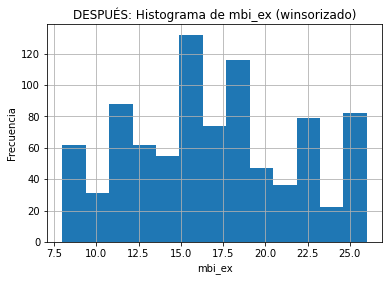

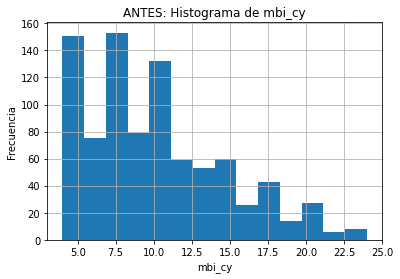

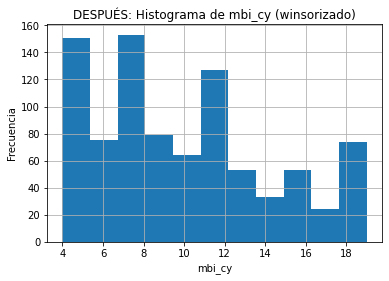

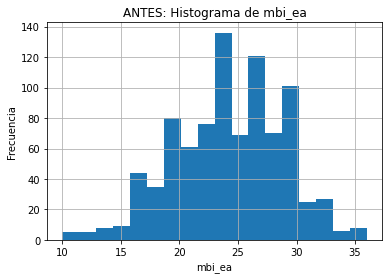

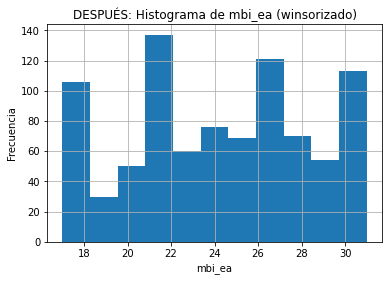

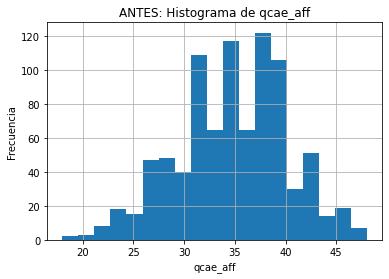

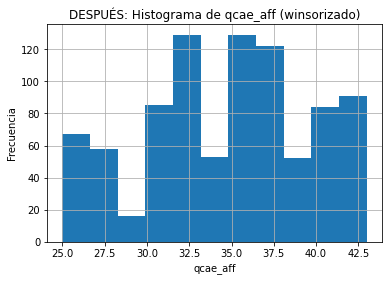

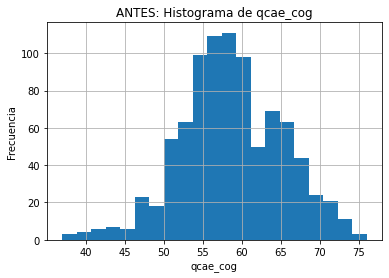

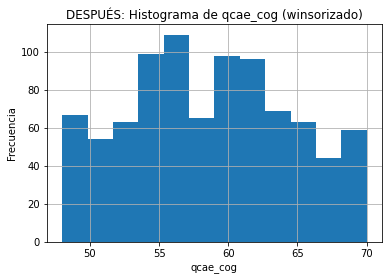

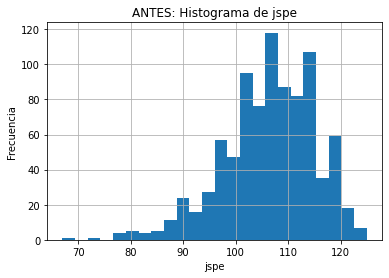

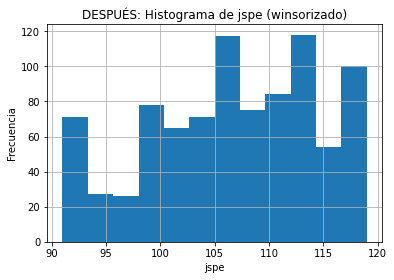

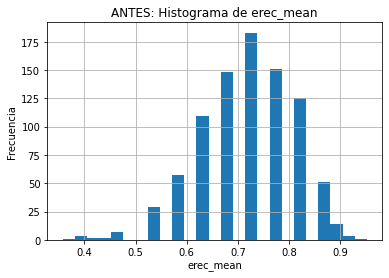

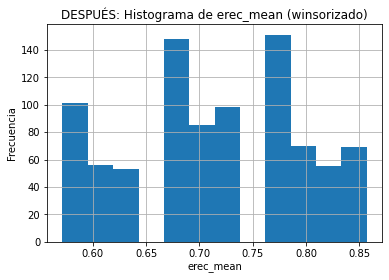

In [13]:
import math

for col in vars_candidates:
    # Histograma antes
    plt.figure()
    plt.hist(data[col].dropna(), bins='auto')
    plt.title(f'ANTES: Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

    # Histograma después
    plt.figure()
    plt.hist(data_wins[col].dropna(), bins='auto')
    plt.title(f'DESPUÉS: Histograma de {col} (winsorizado)')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

## 5. Comparación visual: boxplots antes y después

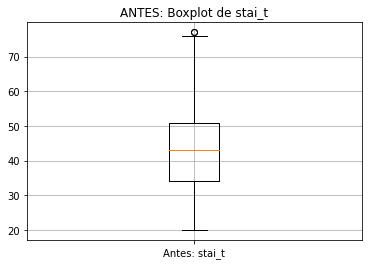

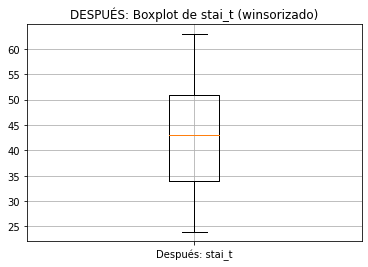

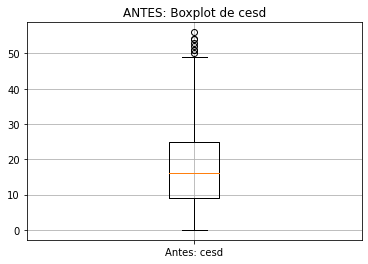

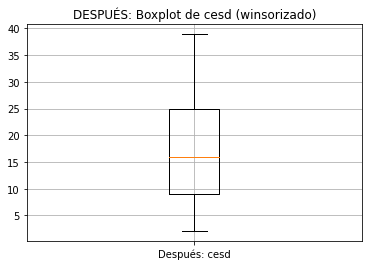

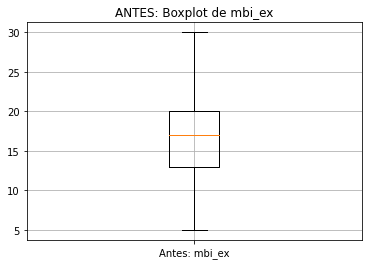

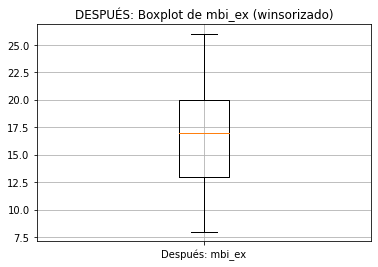

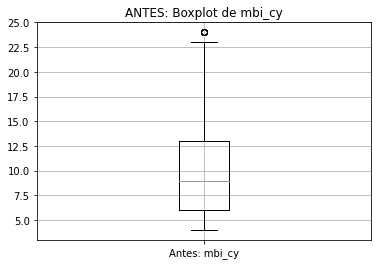

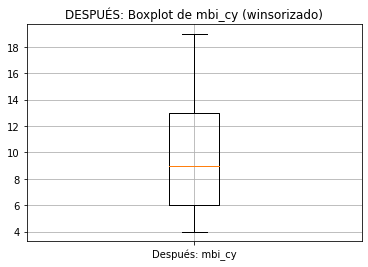

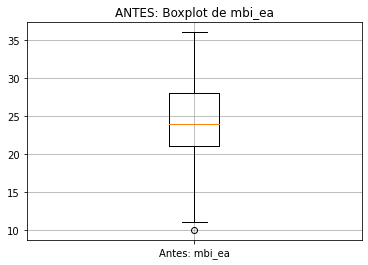

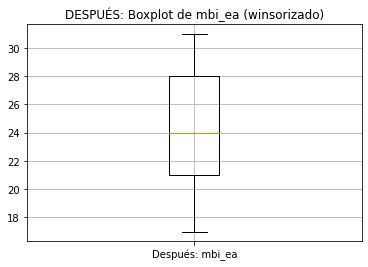

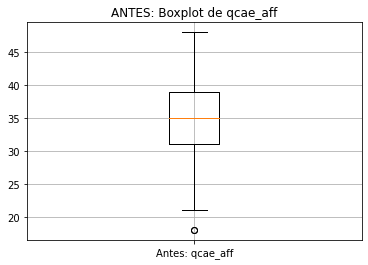

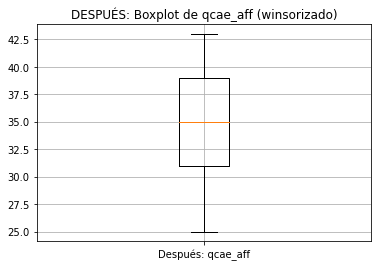

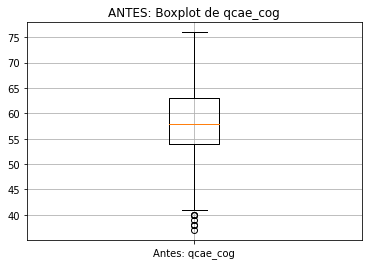

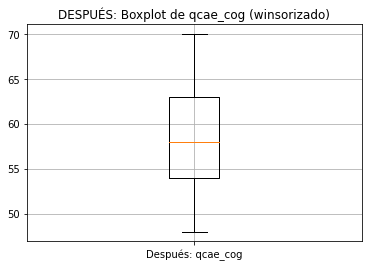

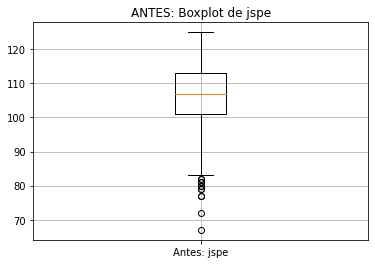

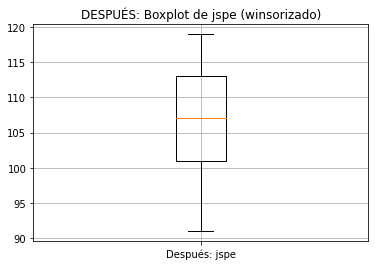

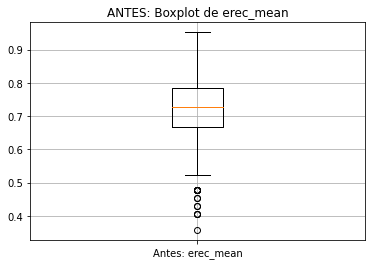

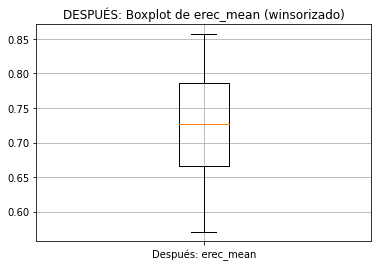

In [14]:
for col in vars_candidates:
    # Boxplot antes
    plt.figure()
    plt.boxplot([data[col].dropna()], labels=[f'Antes: {col}'])
    plt.title(f'ANTES: Boxplot de {col}')
    plt.show()

    # Boxplot después
    plt.figure()
    plt.boxplot([data_wins[col].dropna()], labels=[f'Después: {col}'])
    plt.title(f'DESPUÉS: Boxplot de {col} (winsorizado)')
    plt.show()

## 6. Resumen numérico (media y desviación) antes vs después

In [15]:
summary = []
for col in vars_candidates:
    summary.append({
        'variable': col,
        'mean_before': float(np.nanmean(data[col])),
        'std_before': float(np.nanstd(data[col], ddof=1)),
        'mean_after': float(np.nanmean(data_wins[col])),
        'std_after': float(np.nanstd(data_wins[col], ddof=1)),
    })
summary_df = pd.DataFrame(summary)
summary_df

,variable,mean_before,std_before,mean_after,std_after
0,stai_t,42.898420,11.978458,42.702032,11.233592
1,cesd,18.050790,11.478731,17.785553,10.730455
2,mbi_ex,16.878104,5.256025,16.878104,4.945675
3,mbi_cy,10.079007,4.592609,9.975169,4.348057
4,mbi_ea,24.207675,4.633675,24.234763,4.168373
5,qcae_aff,34.784424,5.377062,34.759594,4.997829
6,qcae_cog,58.525959,6.570341,58.607223,5.992586
7,jspe,106.374718,8.784012,106.563205,7.859498
8,erec_mean,0.720144,0.093570,0.721756,0.083408


## 7. Notas de interpretación

- **Histograma/Boxplot**: después del recorte por percentiles, las colas extremas se reducen.
- **Medias/Desvíos**: suele observarse una **disminución de la desviación estándar** y una media más estable.
- **Precaución**: Ajustá los percentiles (5%–95%, 1%–99%) según el contexto y justificalo.
- **Trazabilidad**: Reportá porcentajes y límites utilizados (`p5`, `p95`) y compará resultados del modelo **antes vs. después**.